In [4]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

In [7]:
season = 'WET_late'

In [8]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_ATTO_{season}_{comment}_{case}_{_x}_{_y}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

In [9]:
plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

In [10]:
xr.set_options(keep_attrs=True) 

## Get observational data

In [11]:
import pandas as pd

In [12]:
high_low_vars = ['N50','N100','N150','N200','N100 (cm^-3)']

In [13]:
from bs_fdbck.constants import path_measurement_data

In [14]:
fn = path_measurement_data / 'SourceData_Yli_Juuti2021.xls'

df_hyy_1 = pd.read_excel(fn, sheet_name=4, header=1,)# usecols=range(7,12),nrows=7)

df_hyy_1.head()
#df_hyy_1y= df_hyy_1y.rename({'year.1':'year',
#                            'T (degree C).1':'T (degree C)',
#                             'OA (microgram m^-3).1':'OA (microgram m^-3)',
#                             'N100 (cm^-3).1':'N100 (cm^-3)'
#                            }, axis=1)
#df_hyy_1y['year'] = pd.to_datetime(df_hyy_1y['year'].apply(x:str(x)))

df_hyy_1

,year,month,day,LAT,LON,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
0,2012,7,5,60.5,22.5,3.218589,191,12.940000,26.219999
1,2012,7,10,60.5,22.5,4.714353,172,10.950000,24.430000
2,2012,7,14,60.5,22.5,1.451827,106,15.790000,12.030000
3,2012,7,19,60.5,22.5,3.101941,262,16.039999,28.650000
4,2012,7,22,60.5,22.5,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
3668,2018,8,13,65.5,29.5,0.674785,191,15.200000,18.969999
3669,2018,8,14,65.5,29.5,1.356364,291,15.200000,31.449999
3670,2018,8,19,65.5,29.5,0.916047,139,18.230000,11.960000
3671,2018,8,20,65.5,29.5,1.325436,177,14.049999,19.869999


In [15]:
import pandas as pd

In [16]:
df_hyy_1['date'] = df_hyy_1.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_1['date'] = pd.to_datetime(df_hyy_1['date'] )

In [17]:
df_hyy_1 = df_hyy_1.set_index(['date','LAT','LON'])

In [18]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
date,LAT,LON,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


## Pick up sizedist info as well

In [19]:
df_hyy_2 = pd.read_excel(fn, sheet_name=0, header=2, usecols=range(6))
df_hyy_2['date'] = df_hyy_2.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_2['date'] = pd.to_datetime(df_hyy_2['date'] )



In [20]:
from bs_fdbck.util.EBAS_data import get_ebas_dataset_Nx_daily_JA_median_df



df_ebas_Nx, ds_ebas_Nx = get_ebas_dataset_Nx_daily_JA_median_df()#x_list = [90,100,110,120])

Importing files: 
[PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20120101000000.20181205100800.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20130101000000.20220222151057.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20140101000000.20220222151057.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20150101000000.20220222151057.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20160101000000.2022022

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(26, 61368)
936.4618444654134 985.0322571360182
406.30625 427.8015
orig, xarray integrate (trapezoidal), constant dlogD, trap2:
985.344136501085 941.5562806424126 427.8015 406.30625
1.0465058295068634 1.0 0.4543557393171613
(22, 61368)
576.933862186921 615.6064516145758
297.64775000000003 307.0885
orig, xarray integrate (trapezoidal), constant dlogD, trap2:
615.7725574292614 580.4231039443305 307.0885 297.64775000000003
1.0609029055609773 1.0 0.5290769749052813
(20, 61368)
435.61068213080813 468.852571193976
258.4085 268.733
orig, xarray integrate (trapezoidal), constant dlogD, trap2:
469.34478625365017 439.3737553553595 268.733 258.4085
1.0682130658305946 1.0 0.611627337146372
(16, 61368)
226.68116710122004 250.40836733695068
122.36275 145.573
orig, xarray integrate (trapezoidal), constant dlogD, trap2:
251.00342993332777 228.17061005858926 145.573 122.36275
1.1000690661644614 1.0 0.6380006608327866
(14, 61368)
116.02642130210195 133.08403363633488
49.91325 62.435500000000005
orig, xa

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/EBAS_data/__init__.py:242: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_JA.mean()
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/EBAS_data/__init__.py:245: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_JA.median())


In [21]:

df_hyy_2['date'] = df_hyy_2.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_2['date'] = pd.to_datetime(df_hyy_2['date'] )


df_hyy_2 = df_hyy_2.set_index('date')

In [22]:
df_hyy_2.index = df_hyy_2.index.rename('time') 

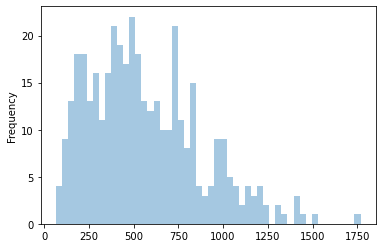

In [23]:
df_hyy_2['N100 (cm^-3)'].plot.hist(bins=50, alpha=0.4, label='obs')

plt.show()



## Why is my method 20% off their method? Is it integration?

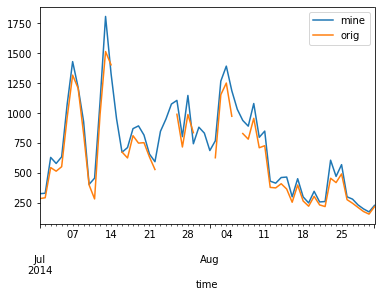

1.13207410632531


In [24]:

df_joint_hyy = pd.merge(df_ebas_Nx, df_hyy_2, left_index=True, right_index=True)
(df_joint_hyy['N100']).loc['2014-07':'2014-09'].plot(label='mine')
(df_joint_hyy['N100 (cm^-3)']).loc['2014-07':'2014-09'].plot(label='orig')
plt.legend()
plt.show()



print(df_joint_hyy['N100'][df_joint_hyy['N100 (cm^-3)'].notnull()].mean()/df_joint_hyy['N100 (cm^-3)'].mean())

In [25]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
date,LAT,LON,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


In [26]:
take_vars = ['N50','N100','N150','N200','N100 (cm^-3)']

In [27]:
import numpy as np

In [28]:
for v in high_low_vars:
    df_hyy_1[v] = np.nan

for d in df_hyy_1.index.get_level_values(0).unique():
    #print(d)
    for v in take_vars:
        df_hyy_1.loc[d,v] = df_joint_hyy.loc[d,v]

/tmp/ipykernel_43986/3996915807.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_hyy_1.loc[d,v] = df_joint_hyy.loc[d,v]


In [29]:
for v in take_vars:
    df_hyy_1[f'{v}_low'] = df_hyy_1[v]<df_hyy_1[v].quantile(.34)
    df_hyy_1[f'{v}_high']= df_hyy_1[v]>df_hyy_1[v].quantile(.66)
    df_hyy_1[f'{v}_category'] = pd.NA#df_hyy_1.assign(OA_category= pd.NA)
    
    df_hyy_1.loc[df_hyy_1[f'{v}_high'], f'{v}_category'] = f'{v} high'
    df_hyy_1.loc[df_hyy_1[f'{v}_low'], f'{v}_category'] = f'{v} low'

In [30]:
high_low_vars

['N50', 'N100', 'N150', 'N200', 'N100 (cm^-3)']

In [31]:
#df_hyy_1['OA_category']

df_hyy_1['OA_low']= df_hyy_1['OA (microgram m^-3)']<2
df_hyy_1['OA_high']= df_hyy_1['OA (microgram m^-3)']>2
ddf_hyy_1=df_hyy_1.assign(OA_category= pd.NA)
df_hyy_1.loc[df_hyy_1['OA_high'], 'OA_category'] = 'OA high'
df_hyy_1.loc[df_hyy_1['OA_low'], 'OA_category'] = 'OA low'



In [32]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

In [33]:
labels=[ 80, 120, 160, 200, 240, 280, 320]

In [34]:
df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 6)#bins=bins, labels=labels)

In [35]:
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)

df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)
di = dict(df_hyy_1.groupby('CWP_cut').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cutlm'] = df_hyy_1['CWP_cut'].apply(lambda x:di[x])

In [36]:
n_bins = 7
labels = np.arange(n_bins)

qants = df_hyy_1['CWP (g m^-2)'].quantile([.05,.95])

bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
df_hyy_1['CWP_cut2']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins2, labels=labels)


di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

df_hyy_1['CWP_cut2l'] = df_hyy_1['CWP_cut2'].apply(lambda x:di_per_lab[x])


di = dict(df_hyy_1.groupby('CWP_cut2').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lm'] = df_hyy_1['CWP_cut2'].apply(lambda x:di[x])

In [37]:
bins2

IntervalIndex([(70.0, 108.85714285714286], (108.85714285714286, 147.71428571428572], (147.71428571428572, 186.57142857142856], (186.57142857142856, 225.42857142857142], (225.42857142857142, 264.2857142857143], (264.2857142857143, 303.1428571428571], (303.1428571428571, 342.0]], dtype='interval[float64, right]')

<AxesSubplot:ylabel='Frequency'>

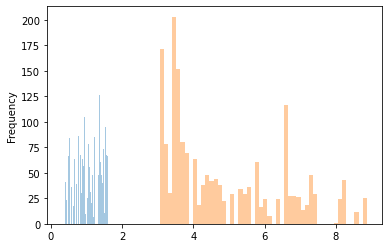

In [38]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_high']].plot.hist(bins=50, alpha=0.4, label='obs')



## Get model data:

In [39]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 

In [40]:
models =[model_name_noresm, model_name_echam]

### Settings

In [41]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [42]:
temperature = 273.15  # K

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

### NorEMS

In [43]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files

In [44]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final{season}.csv'

In [45]:

cases_noresm = [case_name_noresm]

#### Station variables

In [46]:
varl_st_noresm = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
                 ]


varl_cl_noresm = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

### ECHAM-SALSA

In [47]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

#### Input files:

In [48]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [49]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}{season}.csv'

In [50]:

cases_echam = [case_name_echam]

#### Station variables

In [51]:
varl_st_echam = ['mmrtrN500',
                 'mmrtrN250',
                 'mmrtrN200',
                 'mmrtrN100',
                 'mmrtrN50',
                 'mmrtrN3',
                 'SO2_gas',
                 'APIN_gas',
                 'TBETAOCI_gas',
                 'BPIN_gas',
                 'LIMON_gas',
                 'SABIN_gas',
                 'MYRC_gas',
                 'CARENE3_gas',
                 'ISOP_gas',
                 'VBS0_gas',
                 'V*BS1_gas',
                 'VBS10_gas',
                 'ORG_mass',
                 'oh_con',
                 'tempair',
                 'ccn02',
                 'ccn10',

          ]


varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
           ]

### READ CVS

In [52]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )

<AxesSubplot:ylabel='Frequency'>

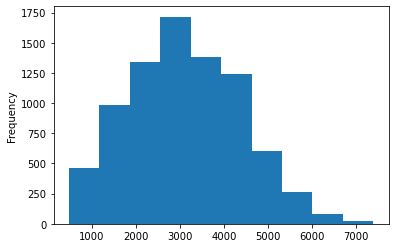

In [53]:
df_mod_noresm['N100'].plot.hist()

In [54]:
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2] )

<AxesSubplot:ylabel='Frequency'>

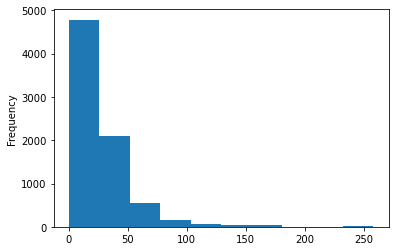

In [55]:
df_mod_echam['N200'].plot.hist()

In [56]:
df_hyy_1.index = df_hyy_1.index.rename({'LAT':'lat', 'LON':'lon','date':'time'})

In [57]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df['Observations'] = df_hyy_1

In [58]:
df_mod_noresm[df_mod_noresm['isSummer'].notnull()]

TOT_ICLD_VISTAU  EC550AER      FLUTC  OD550DRY  \
time       lat       lon                                                      
2012-01-02 -7.068063 293.75              NaN       NaN        NaN       NaN   
                     295.00              NaN       NaN        NaN       NaN   
                     296.25              NaN       NaN        NaN       NaN   
                     297.50              NaN       NaN        NaN       NaN   
                     298.75              NaN       NaN        NaN       NaN   
...                                      ...       ...        ...       ...   
2018-05-31 -1.413613 302.50         0.000000  0.000038  281.37085  0.053408   
                     303.75         0.000000  0.000043  283.28820  0.051337   
                     305.00              NaN       NaN        NaN       NaN   
                     306.25         0.000000  0.000056  279.38232  0.045126   
                     307.50         1.215826  0.000143  277.15314  0.044204   

                               SO4_AC         NMR03   SIGMA05   DERLT05  \
time       lat       lon                                                  
2012-01-02 -7.068063 293.75       NaN           NaN       NaN       NaN   
                     295.00       NaN           NaN       NaN       NaN   
                     296.25       NaN           NaN       NaN       NaN   
                     297.50       NaN           NaN       NaN       NaN   
                     298.75       NaN           NaN       NaN       NaN   
...                               ...           ...       ...       ...   
2018-05-31 -1.413613 302.50  0.001028  4.000000e-08  1.449225  0.084254   
                     303.75  0.001025  4.000000e-08  1.445571  0.085598   
                     305.00       NaN           NaN       NaN       NaN   
                     306.25  0.001016  4.000000e-08  1.438638  0.086221   
                     307.50  0.001025  4.000000e-08  1.473909  0.084009   

                              FSNTCDRF  NCONC03  ...  ismonth4  ismonth5  \
time       lat       lon                         ...                       
2012-01-02 -7.068063 293.75        NaN      NaN  ...       0.0       0.0   
                     295.00        NaN      NaN  ...       0.0       0.0   
                     296.25        NaN      NaN  ...       0.0       0.0   
                     297.50        NaN      NaN  ...       0.0       0.0   
                     298.75        NaN      NaN  ...       0.0       0.0   
...                                ...      ...  ...       ...       ...   
2018-05-31 -1.413613 302.50  418.06497      0.0  ...       0.0       1.0   
                     303.75  562.80330      0.0  ...       0.0       1.0   
                     305.00        NaN      NaN  ...       0.0       1.0   
                     306.25  815.74930      0.0  ...       0.0       1.0   
                     307.50  622.01060      0.0  ...       0.0       1.0   

                             isJuly  isAug  isJA  isSummer    ilev  \
time       lat       lon                                             
2012-01-02 -7.068063 293.75     0.0    0.0   0.0       1.0  1000.0   
                     295.00     0.0    0.0   0.0       1.0  1000.0   
                     296.25     0.0    0.0   0.0       1.0  1000.0   
                     297.50     0.0    0.0   0.0       1.0  1000.0   
                     298.75     0.0    0.0   0.0       1.0  1000.0   
...                             ...    ...   ...       ...     ...   
2018-05-31 -1.413613 302.50     0.0    0.0   0.0       1.0  1000.0   
                     303.75     0.0    0.0   0.0       1.0  1000.0   
                     305.00     0.0    0.0   0.0       1.0  1000.0   
                     306.25     0.0    0.0   0.0       1.0  1000.0   
                     307.50     0.0    0.0   0.0       1.0  1000.0   

                                    lev  station  year  
time       lat       lon                                
2012-01-02 

In [59]:
df_mod_echam[df_mod_echam['isSummer'].notnull()]

ORG_mass   airdens  aot550nm        ccn02  \
time       lat       lon                                                      
2012-03-01 -2.797890 294.375  1.035651e-09  1.138874  0.355155  109982290.0   
                     296.250           NaN       NaN       NaN          NaN   
                     298.125  9.570835e-10  1.181735  0.180115  100442780.0   
                     300.000  1.189990e-09  1.165295  0.134060  122890480.0   
                     301.875  1.108639e-09  1.154503  0.097090  116885380.0   
...                                    ...       ...       ...          ...   
2018-05-31 -6.528409 300.000           NaN       NaN       NaN          NaN   
                     301.875           NaN       NaN       NaN          NaN   
                     303.750           NaN       NaN       NaN          NaN   
                     305.625           NaN       NaN       NaN          NaN   
                     307.500           NaN       NaN       NaN          NaN   

                                    ccn10      ceff    ceff_ct  cl_time  \
time       lat       lon                                                  
2012-03-01 -2.797890 294.375  467541900.0  0.000007   7.666917    1.000   
                     296.250          NaN       NaN        NaN      NaN   
                     298.125  439552320.0  0.000000  11.124208    0.000   
                     300.000  488321340.0  0.000011   9.023733    0.875   
                     301.875  481783170.0  0.000007   6.883420    1.000   
...                                   ...       ...        ...      ...   
2018-05-31 -6.528409 300.000          NaN       NaN        NaN      NaN   
                     301.875          NaN       NaN        NaN      NaN   
                     303.750          NaN       NaN        NaN      NaN   
                     305.625          NaN       NaN        NaN      NaN   
                     307.500          NaN       NaN        NaN      NaN   

                                  clfr        cod  ...  month  ismonth3  \
time       lat       lon                           ...                    
2012-03-01 -2.797890 294.375  1.000000  12.283052  ...    3.0       1.0   
                     296.250       NaN        NaN  ...    3.0       1.0   
                     298.125  0.000000   8.919573  ...    3.0       1.0   
                     300.000  0.171906  15.582723  ...    3.0       1.0   
                     301.875  0.016052  28.375870  ...    3.0       1.0   
...                                ...        ...  ...    ...       ...   
2018-05-31 -6.528409 300.000       NaN        NaN  ...    5.0       0.0   
                     301.875       NaN        NaN  ...    5.0       0.0   
                     303.750       NaN        NaN  ...    5.0       0.0   
                     305.625       NaN        NaN  ...    5.0       0.0   
                     307.500       NaN        NaN  ...    5.0       0.0   

                              ismonth4  ismonth5  isJuly  isAug  isJA  \
time       lat       lon                                                
2012-03-01 -2.797890 294.375       0.0       0.0     0.0    0.0   0.0   
                     296.250       0.0       0.0     0.0    0.0   0.0   
                     298.125       0.0       0.0     0.0    0.0   0.0   
                     300.000       0.0       0.0     0.0    0.0   0.0   
                     301.875       0.0       0.0     0.0    0.0   0.0   
...                                ...       ...     ...    ...   ...   
2018-05-31 -6.528409 300.000       0.0       1.0     0.0    0.0   0.0   
                     301.875       0.0       1.0     0.0    0.0   0.0   
                     303.750       0.0       1.0     0.0    0.0   0.0   
                     305.625       0.0       1.0     0.0    0.0   0.0   
                     307.500       0.0       1.0     0.0    0.0   0.0   

                              isSummer   lev  year  
time       lat       lon                           

# Mask data

### NorESM

## Masking if less than 10% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

In [60]:
df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.1) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)


df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

<AxesSubplot:xlabel='TGCLDCWP', ylabel='CWP'>

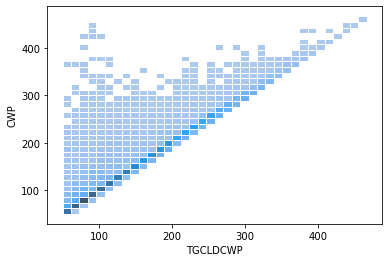

In [61]:
v_x = 'TGCLDCWP'
#ax = axs[1]
df_mod = dic_df[model_name_noresm]

_df = (df_mod[df_mod[v_x].notnull()])#[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]>50]
_df = _df[_df[v_x]<10000]
sns.histplot(
    x=v_x,
    y= 'CWP',
    data=_df,
    #hue=v_hue,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    palette = 'Set1',
    edgecolor='w',
)

## ECHAM

In [62]:
df_mod = dic_df[model_name_noresm]

In [63]:
#mask_cl_waterpath = df_mod['cwp']>50

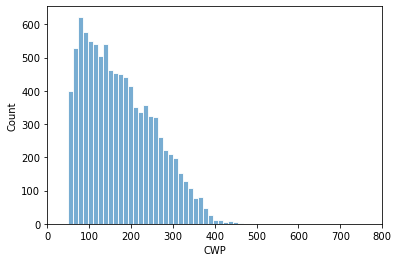

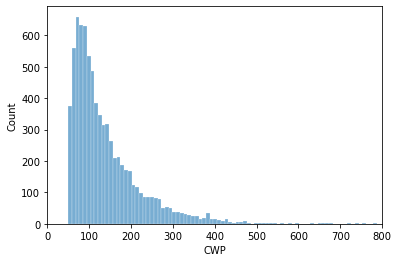

(0.0, 1000.0)

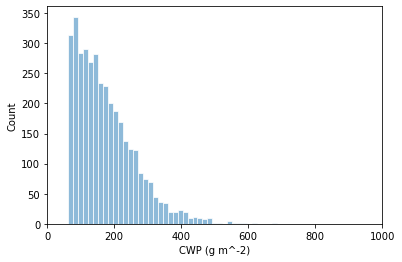

In [64]:
#(1000*df_mod['cwp']).plot.hist()
v_x = 'CWP'
#ax = axs[1]
df_mod = dic_df[model_name_noresm]

_df = (df_mod[df_mod[v_x].notnull()])#[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]>50]
_df = _df[_df[v_x]<10000]
sns.histplot(
    x=v_x,
    data=_df,
    #hue=v_hue,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    palette = 'Set1',
    alpha=.6,
    edgecolor='w',
)
plt.xlim([0,800])
plt.show()
v_x = 'CWP'
#ax = axs[1]
df_mod = dic_df[model_name_echam]

_df = (df_mod)#[(df_mod['OA_category'].notna())])
#_df = _df[_df[v_x]>50]
sns.histplot(
    x=v_x,
    data=_df,
    #hue=v_hue,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    palette = 'Set1',
    alpha=.6,
    edgecolor='w',
)
plt.xlim([0,800])
plt.show()

v_x = 'CWP (g m^-2)'
_df = (dic_df['Observations'])#[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]>50]
sns.histplot(
    x=v_x,
    data=_df,
    #hue=v_hue,
    palette = 'hls',
    alpha=.5,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    #palette = _palette,
    edgecolor='w',
)
plt.xlim([0,1000])

In [65]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'Observations'])

### Remove grid vells with no cloud top liquid

More than 10% cloud top liquid fraction in grid cell and 90% of the cloud fraction is covered by liquid. 

## Rename 


In [66]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    
    
}
rn_dic_noresm = {
    'TGCLDCWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}



In [67]:
dic_df['ECHAM-SALSA']['CWP']

time        lat        lon    
2012-01-01  -2.797890  294.375   NaN
                       296.250   NaN
                       298.125   NaN
                       300.000   NaN
                       301.875   NaN
                                  ..
2018-12-31  -6.528409  300.000   NaN
                       301.875   NaN
                       303.750   NaN
                       305.625   NaN
                       307.500   NaN
Name: CWP, Length: 61368, dtype: float64

In [68]:
for key, rn in zip([model_name_noresm, model_name_echam,'Observations'], [rn_dic_noresm, rn_dic_echam, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

## Group by cloud water path

In [69]:
pd.to_datetime(df_mod.reset_index()['time']).dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [70]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

In [71]:
df_mod = dic_df[model_name_noresm]

v = 'CLDFREE'
df_mod[v].quantile(.99)

0.2927063697999981

In [72]:
df_mod[v].mean()

0.019442372631796066

In [73]:
df_mod[v].max()

1.0

In [74]:
df_mod[v].min()

0.0

for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod
    

    df_mod = dic_df[model_name]
    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)


    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)


    df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)


In [75]:
for model_name in models:
    print(model_name)
    df_mod = dic_df[model_name]
    # Optical thickness > 50:
    df_mod = df_mod[df_mod['CWP']>=50]

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    n_bins = 7
    labels = np.arange(n_bins)

    qants = df_mod['CWP'].quantile([.05,.95])

    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    
    
    df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
    df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)
    mid_range = ( df_mod['OA'].quantile(.34)<df_mod['OA']) & (df_mod['OA']<df_mod['OA'].quantile(.66))
    df_mod['OA_mid_range'] = mid_range
    df_mod=df_mod.assign(OA_category= pd.NA)
    df_mod.loc[df_mod['OA_high'], 'OA_category'] = 'OA high'
    df_mod.loc[df_mod['OA_low'], 'OA_category'] = 'OA low'
    
    
    
    
    for v in high_low_vars:
        if v not in df_mod.columns:
            continue 
        df_mod[f'{v}_low'] = df_mod[v]<df_mod[v].quantile(.34)
        df_mod[f'{v}_high']= df_mod[v]>df_mod[v].quantile(.66)
        df_mod[f'{v}_category'] = pd.NA#df_hyy_1.assign(OA_category= pd.NA)
    
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
    
    
    dic_df[model_name] = df_mod
    
    
    
    
for model_name in [model_name_noresm]:
    df_mod = dic_df[model_name]
    v = 'CLDFREE'
    df_mod[f'{v}_low'] = df_mod[v]<df_mod[v].quantile(.34)
    df_mod[f'{v}_high']= df_mod[v]>df_mod[v].quantile(.66)
    mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
    df_mod[f'{v}_mid_range'] = mid_range
    df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
    df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
    df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
    dic_df[model_name] = df_mod

NorESM
ECHAM-SALSA


/tmp/ipykernel_43986/970158435.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)
/tmp/ipykernel_43986/970158435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
/tmp/ipykernel_43986/970158435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [76]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

## Category of OA concentration

## Distribution plots:

In [77]:
palette = 'Set2'

In [78]:
import numpy as np

In [79]:
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [80]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

In [81]:
palette_OA = cmap_list[0:2]

3673
Plots/dist_plot/cloud_props_ATTO_WET_late_distribution_mod_obs_COT_count.png


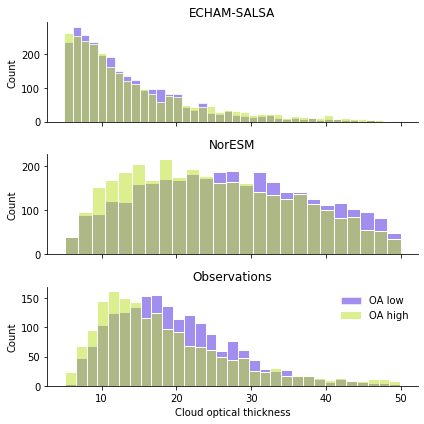

In [82]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100

v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



3659
Plots/dist_plot/cloud_props_ATTO_WET_late_distribution_mod_obs_CWP_count.png


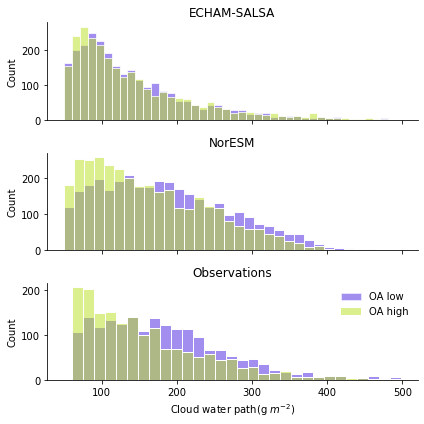

In [83]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])

v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [84]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

7767

7767
9730
3673
Plots/dist_plot/cloud_props_ATTO_WET_late_distribution_mod_obs_r_eff_count.png


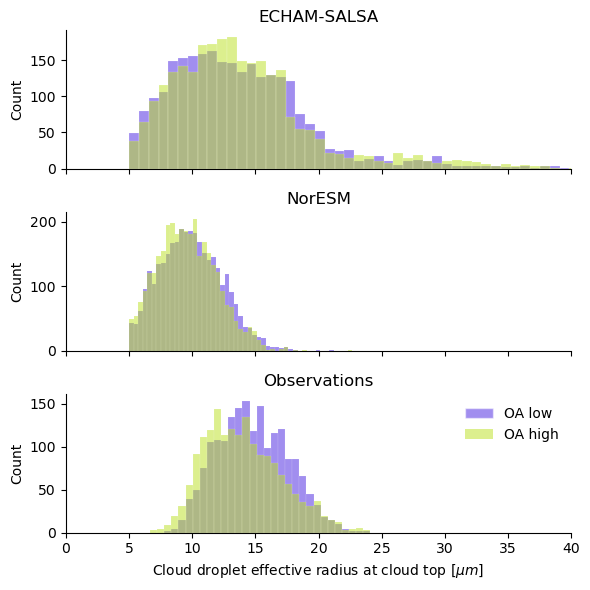

In [85]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



### Fractional occurance of cloud top liquid

## Cloud optical thickness

### Incloud

In [86]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [87]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_ATTO_WET_late_boxen_swarm_N100_category_COT_CWP_cut2l.png


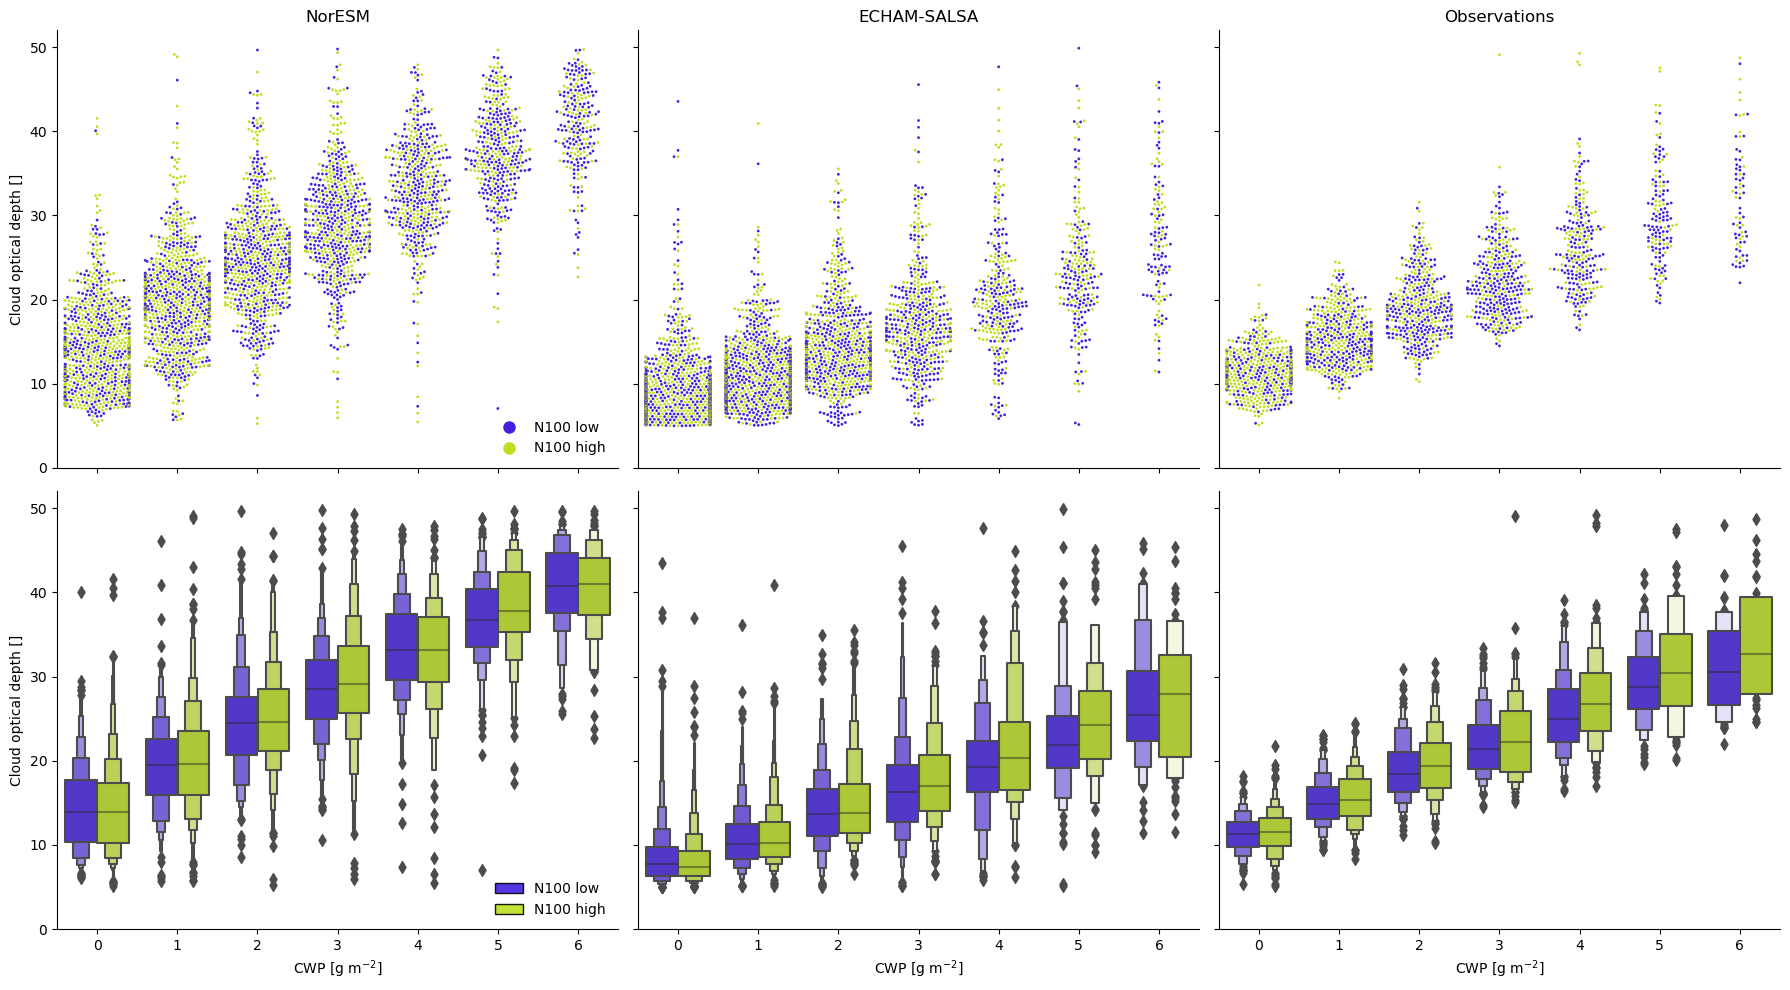

In [88]:
x_var = 'CWP_cut2l'
y_var = 'COT'
hue_var = 'N100_category'
hue_labs = ['N100 low', 'N100 high']

v_hue = 'N100_category'
category = 'N100_category'


hue_order=['N100 low', 'N100 high']#[::-1]

ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_ATTO_WET_late_boxen_swarm_N200_category_COT_CWP_cut2l.png


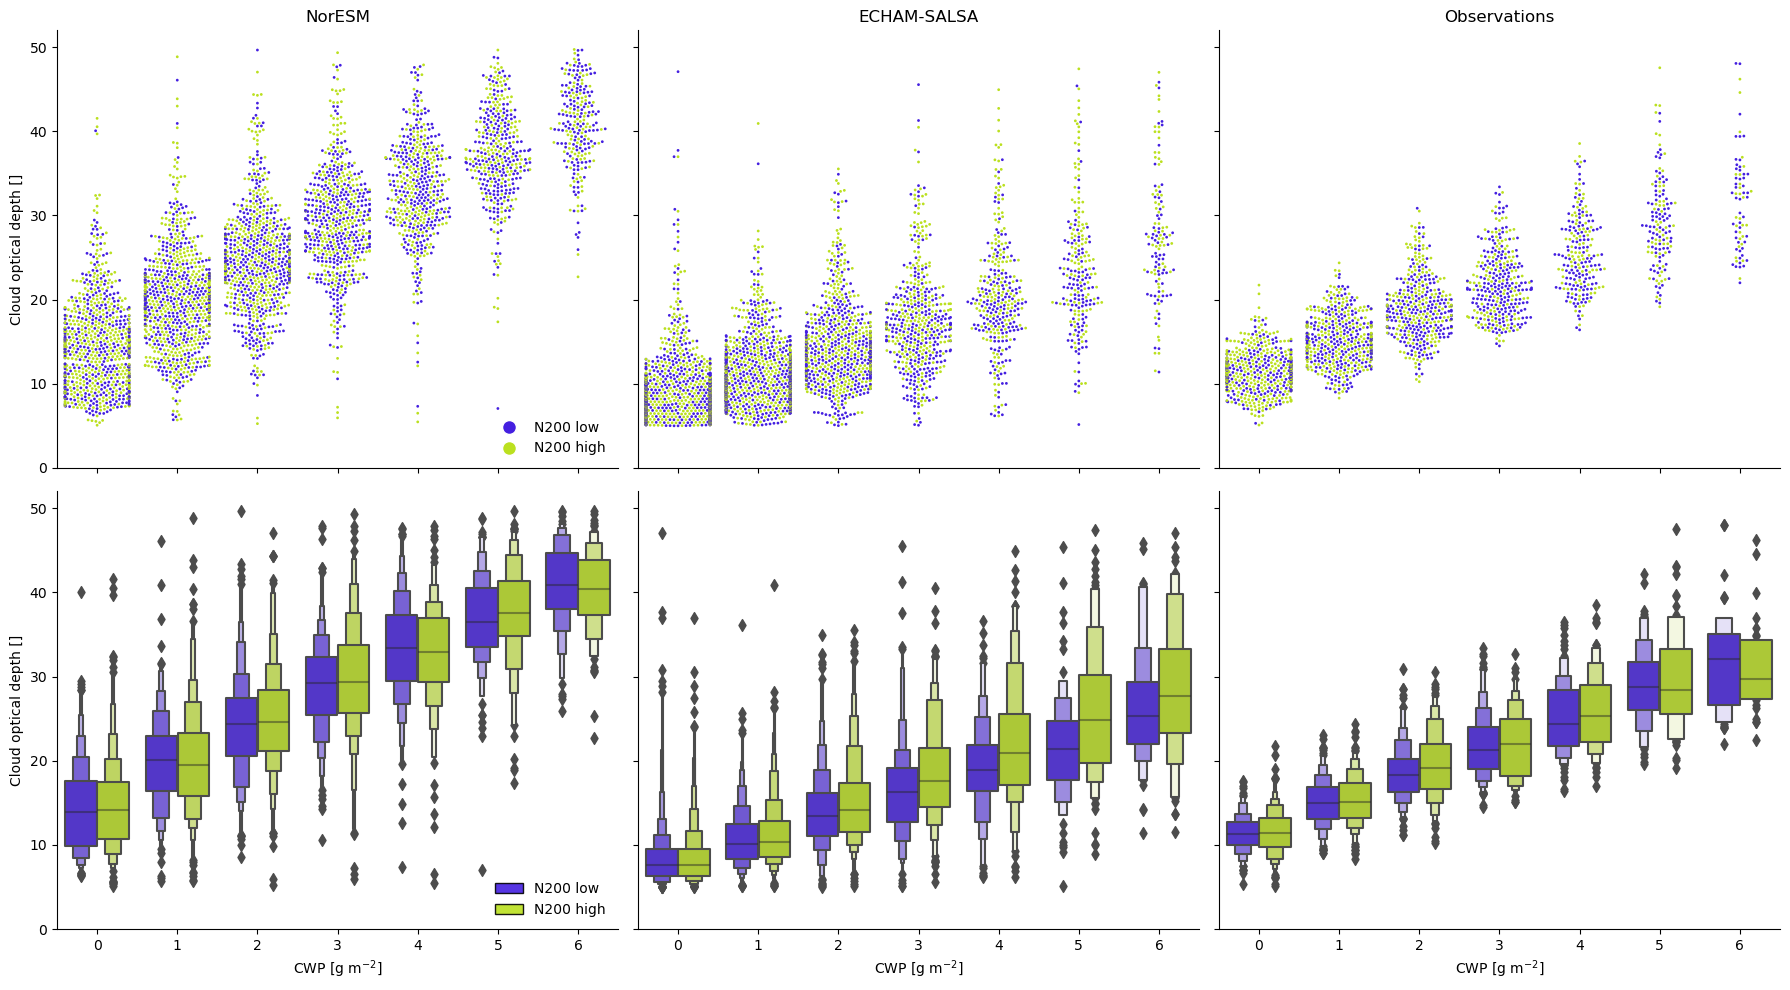

In [89]:
x_var = 'CWP_cut2l'
y_var = 'COT'
hue_var = 'N200_category'
hue_labs = ['N200 low', 'N200 high']

v_hue = 'N200_category'
category = 'N200_category'


hue_order=['N200 low', 'N200 high']#[::-1]

ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_ATTO_WET_late_boxen_swarm_N50_category_COT_CWP_cut2l.png


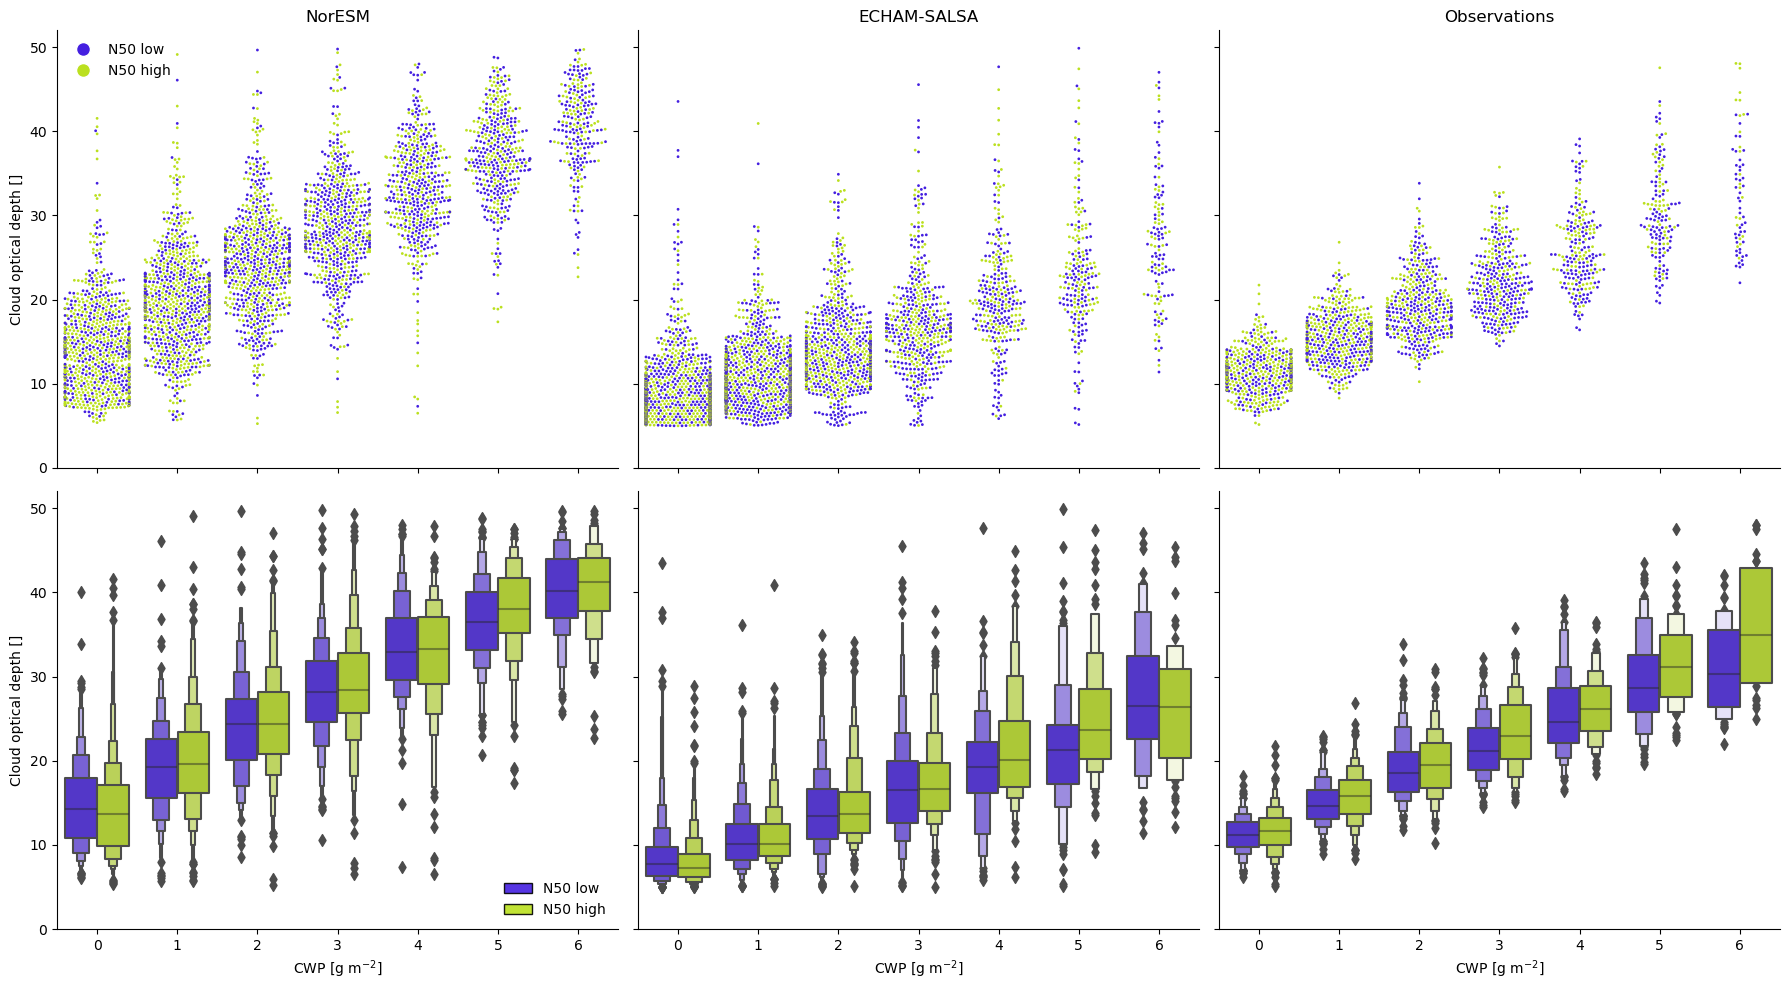

In [90]:
x_var = 'CWP_cut2l'
y_var = 'COT'
hue_var = 'N50_category'
hue_labs = ['N50 low', 'N50 high']

v_hue = 'N50_category'
category = 'N50_category'


hue_order=['N50 low', 'N50 high']#[::-1]

ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_ATTO_WET_late_boxen_swarm_OA_category_COT_CWP_cutlm.png


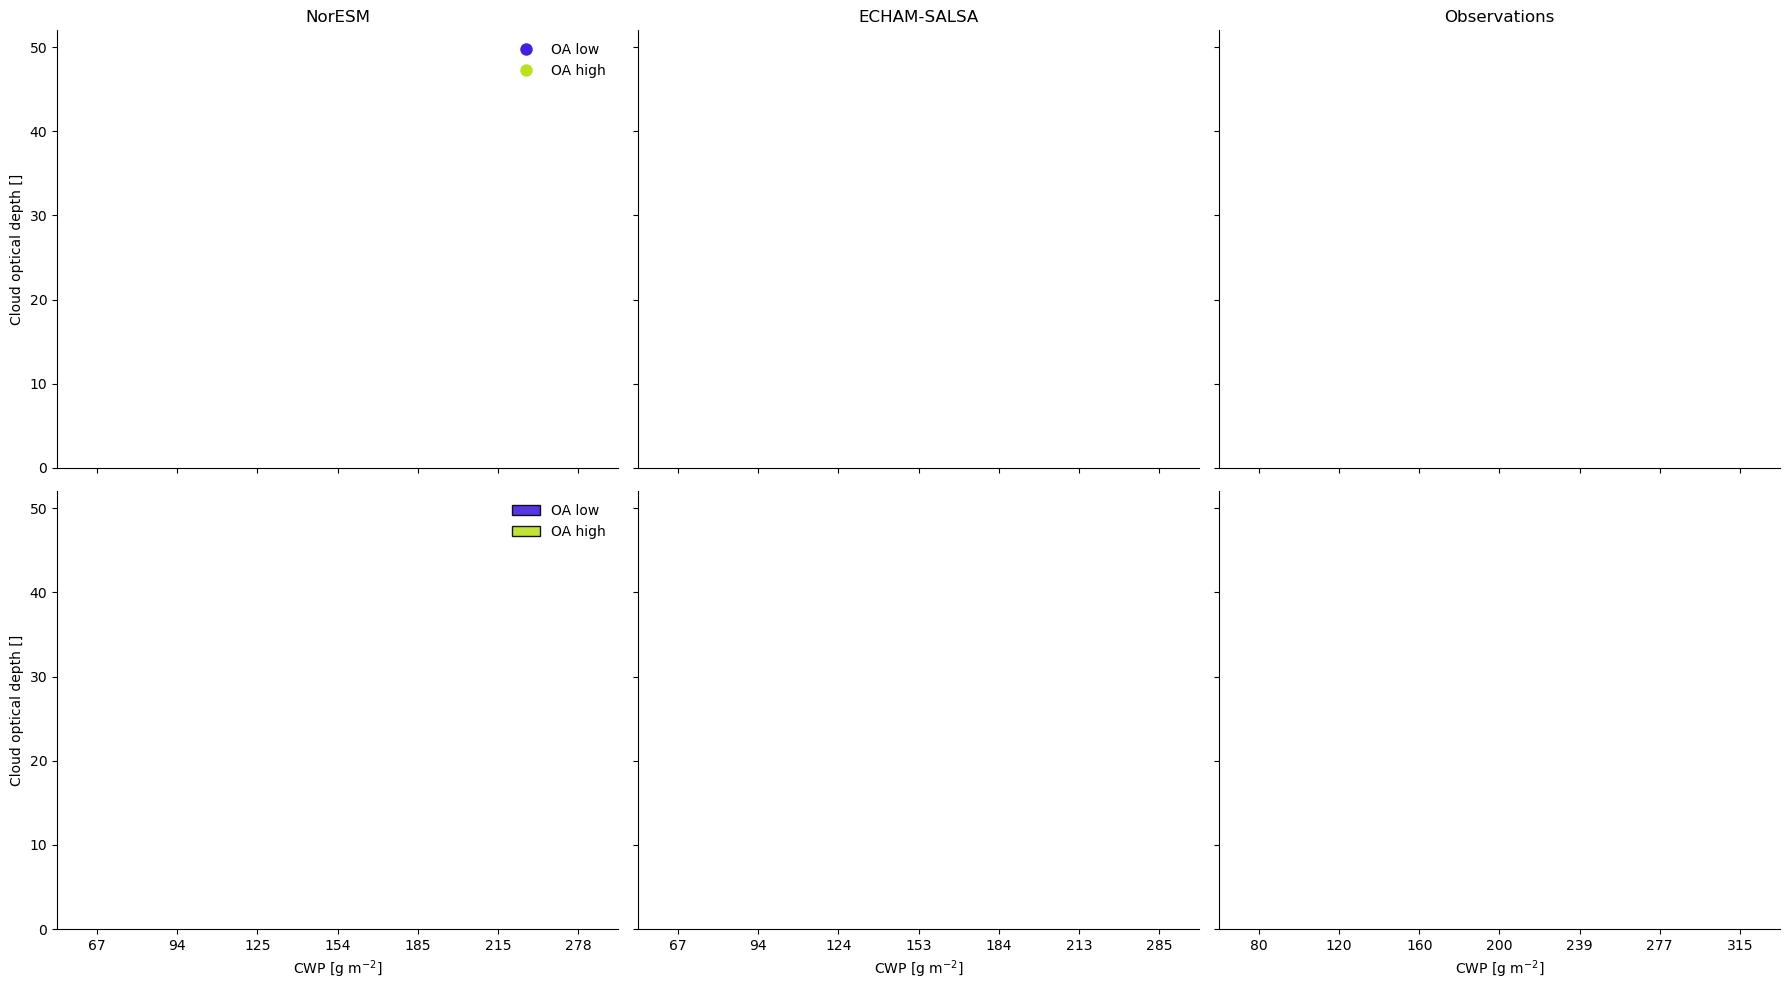

In [91]:
x_var = 'CWP_cutlm'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_ATTO_WET_late_boxen_swarm_OA_category_r_eff_CWP_cutlm.png


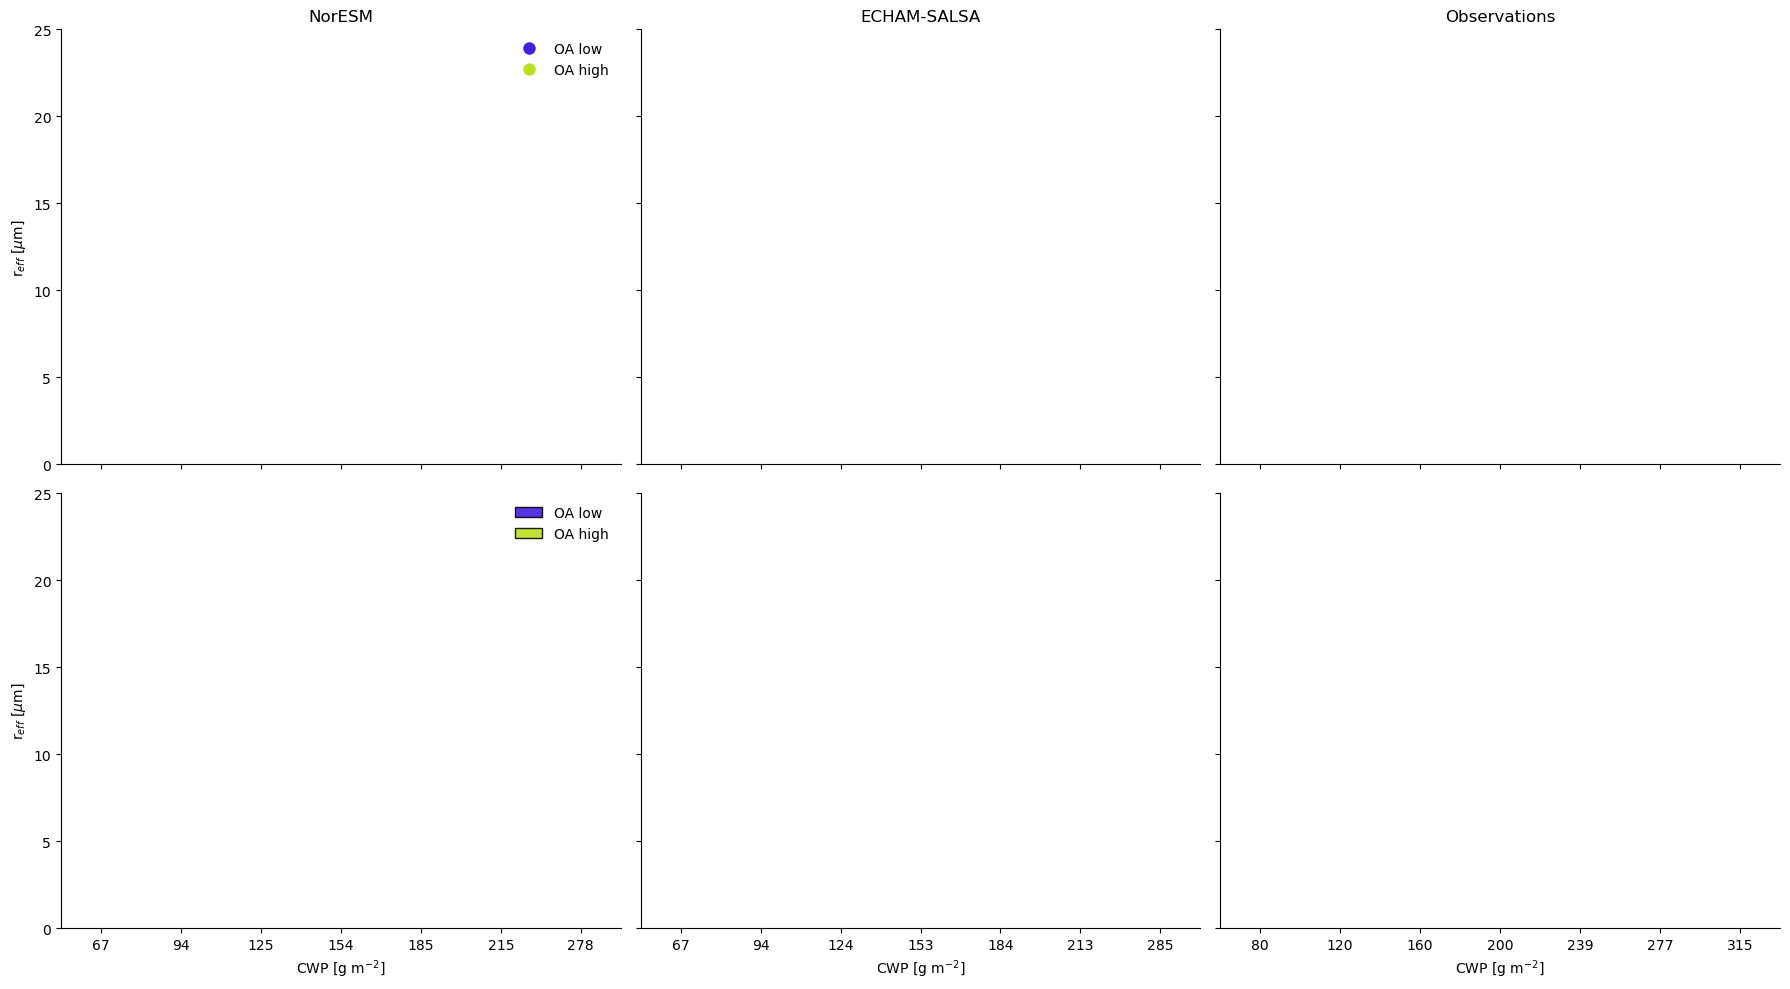

In [92]:
x_var = 'CWP_cutlm'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_ATTO_WET_late_boxen_swarm_OA_category_r_eff_CWP_cut2l.png


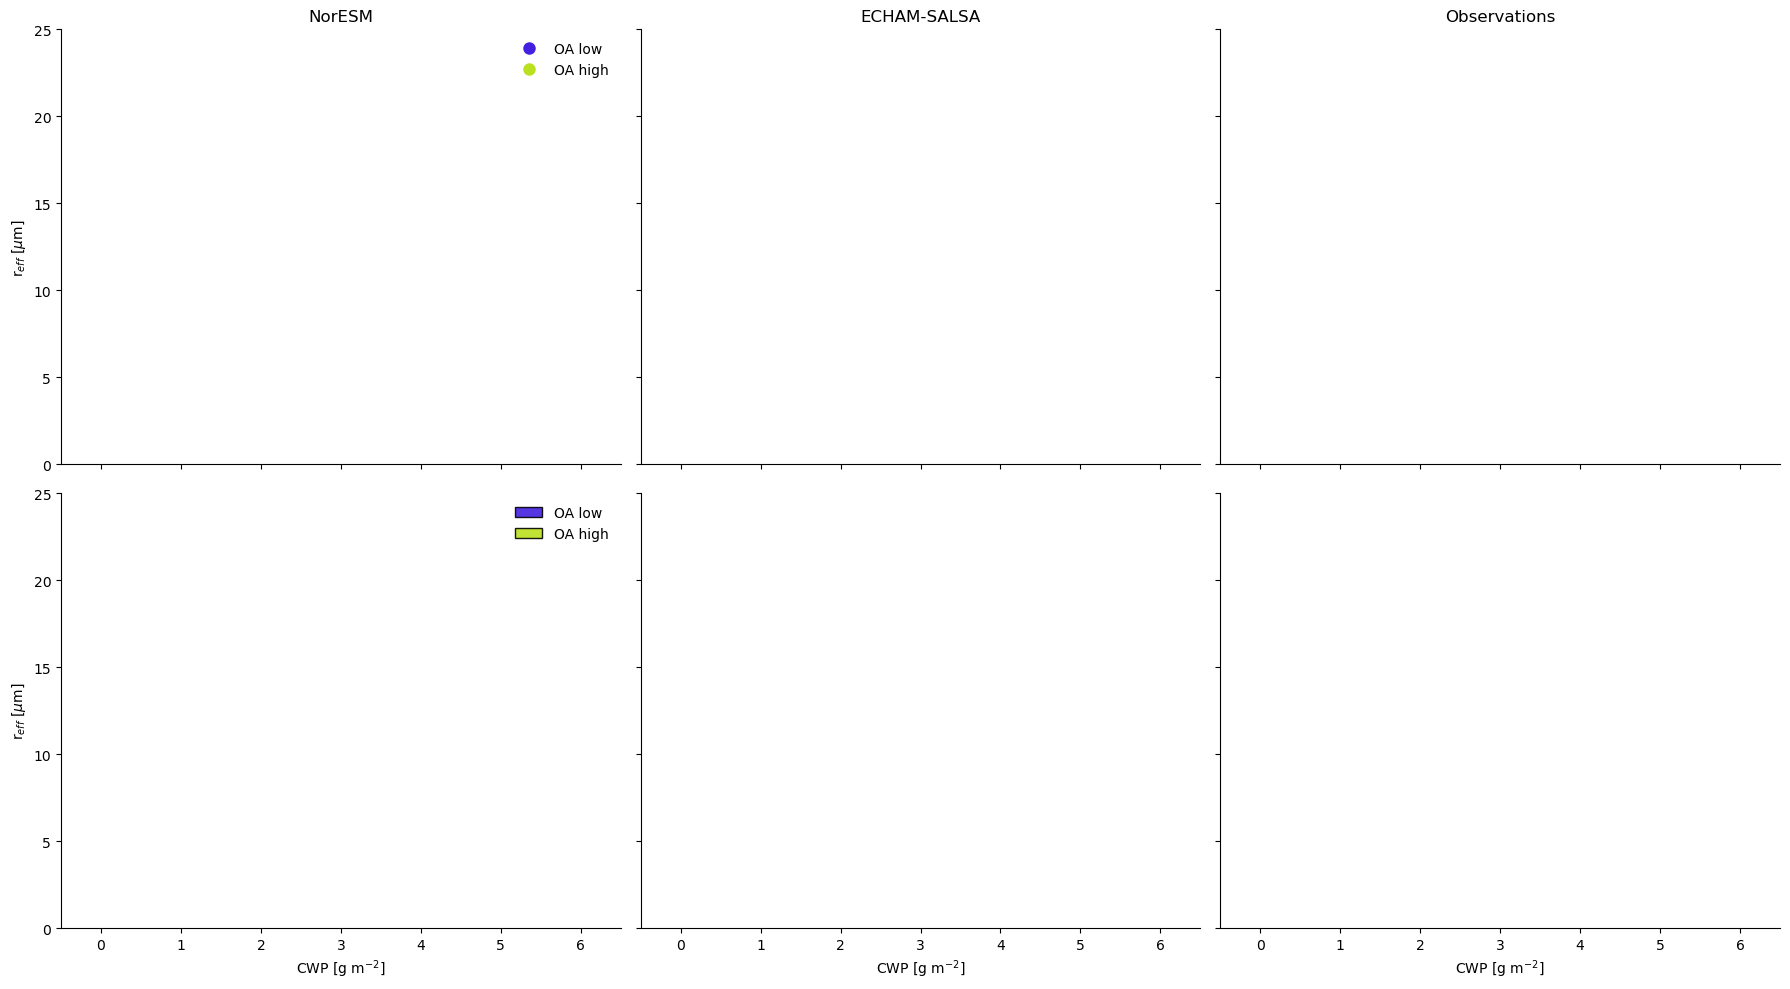

In [93]:
x_var = 'CWP_cut2l'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()

### Grid box avg

Plots/rel_plot/cloud_props_ATTO_WET_late_boxen_swarm_OA_category_r_eff_CWP_cut2lm.png


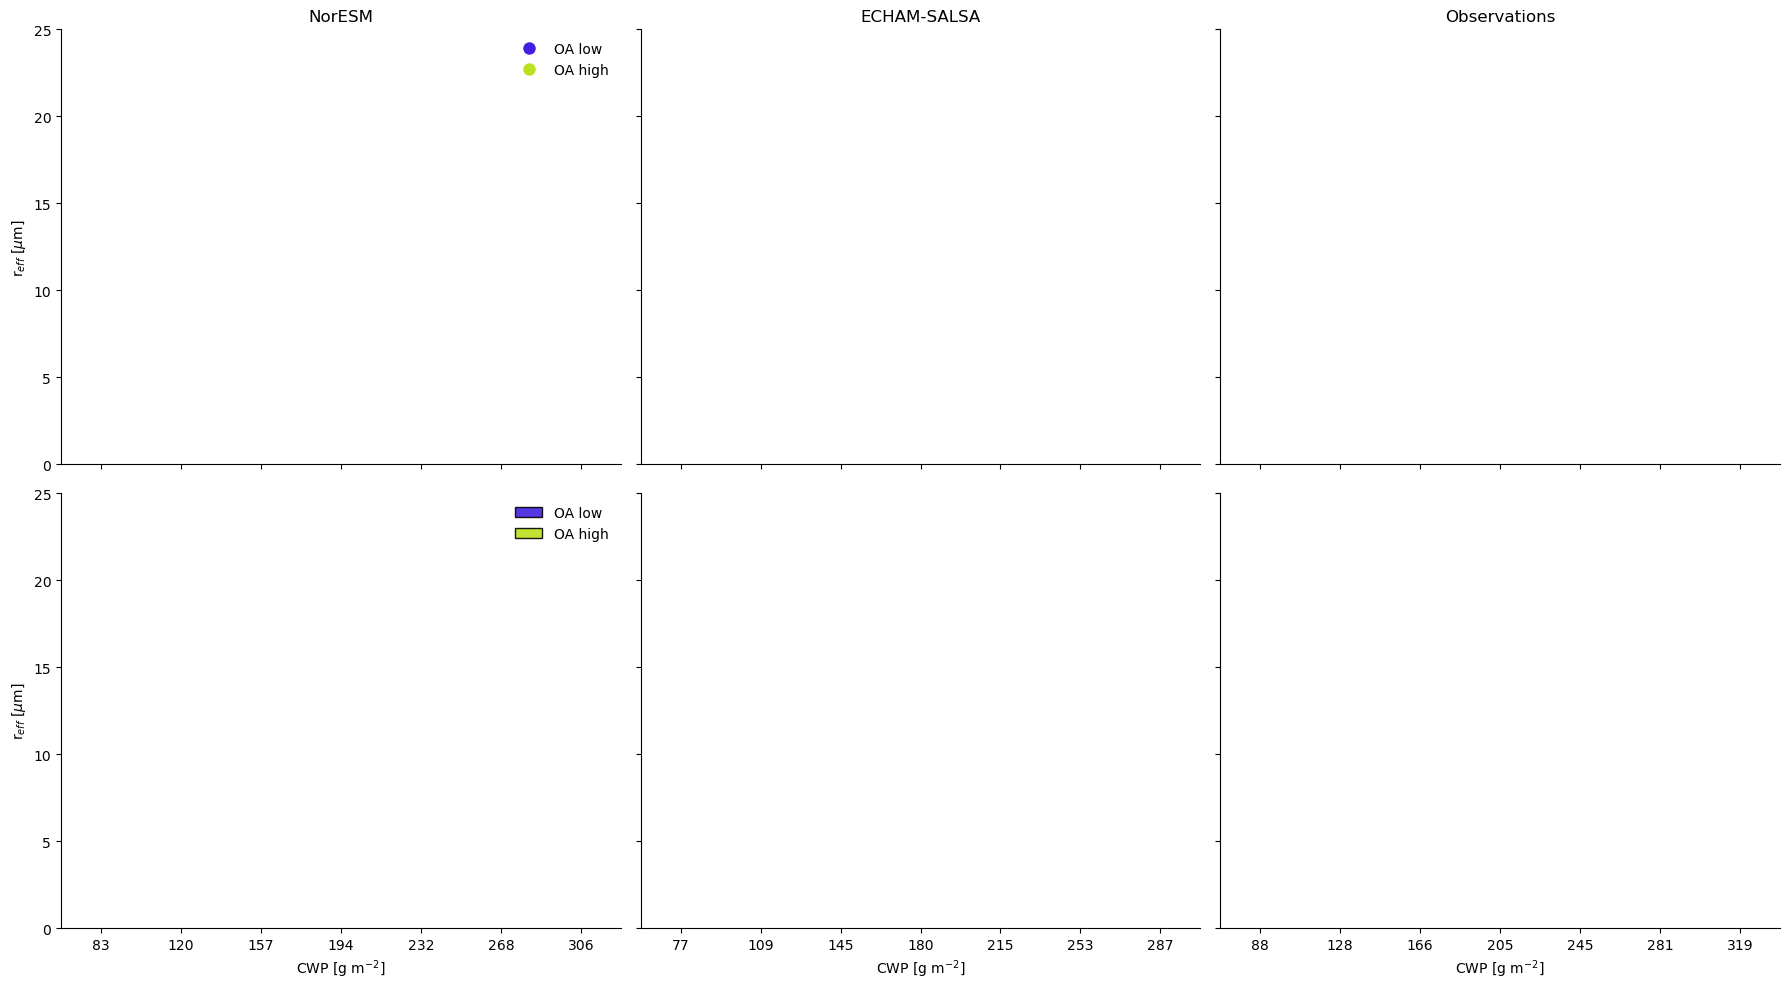

In [94]:
x_var = 'CWP_cut2lm'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()

### Grid box avg

In [95]:
_df = dic_df[key]

In [96]:
_df.groupby('CWP_cut').count()['OA']

CWP_cut
(60, 100]     852
(100, 140]    753
(140, 180]    640
(180, 220]    511
(220, 260]    359
(260, 300]    235
(300, 340]    137
Name: OA, dtype: int64

In [97]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

## Difference plot

NameError: name 'alpha_err' is not defined

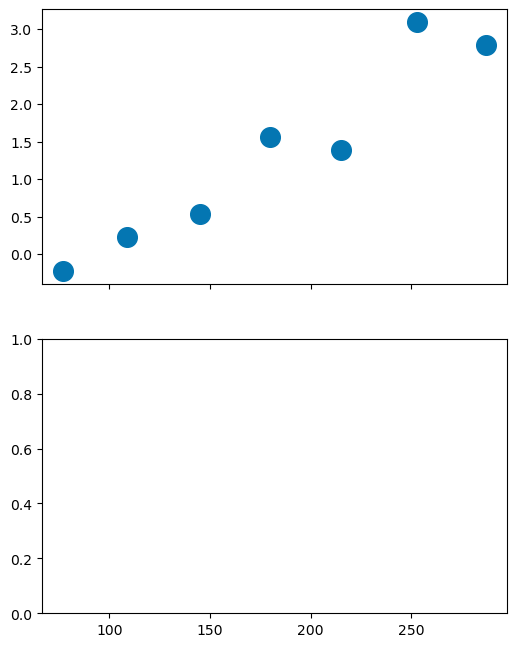

In [98]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 = [-4,4]
# fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)

markersize= 2


fig, axs = plt.subplots(2,1,figsize=figsize, sharey='row', sharex='col', dpi=100)


x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    for key in dic_df.keys():
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
    
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        std_low = _df_low.groupby(x_var).std()
        std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()
        n_high = _df_high.groupby(x_var).count()
    
        diff_med = med_high-med_low
        z_alph = 1.96
    
        pm_int = z_alph*np.sqrt((std_low**2/n_low + std_high**2/n_high))
    
        ax.scatter(diff_med.index, diff_med[y_var], c=cdic_model[key], label=key,s=200)
        ax.errorbar(diff_med.index, diff_med[y_var], yerr=pm_int[y_var], c=cdic_model[key], linewidth=0, elinewidth=8, alpha=alpha_err)

for ax in axs:
    ax.axhline(0, c='k')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

axs[0].set_title('Difference between high OA and low OA')



sns.despine(fig)
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

In [ ]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

# fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)

markersize= 2


fig, axs = plt.subplots(2,1,figsize=figsize, sharey='row', sharex='col', dpi=100)


x_var = 'CWP_cutlm'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    for key in dic_df.keys():
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
    
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        std_low = _df_low.groupby(x_var).std()
        std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()
        n_high = _df_high.groupby(x_var).count()
    
        diff_med = med_high-med_low
        z_alph = 1.96
    
        pm_int = z_alph*np.sqrt((std_low**2/n_low + std_high**2/n_high))
    
        ax.scatter(diff_med.index, diff_med[y_var], c=cdic_model[key], label=key,s=200)
        ax.errorbar(diff_med.index, diff_med[y_var], yerr=pm_int[y_var], c=cdic_model[key], linewidth=0, elinewidth=8, alpha=alpha_err)

for ax in axs:
    ax.axhline(0, c='k')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

axs[0].set_title('Difference between high OA and low OA')



sns.despine(fig)
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

In [ ]:
figsize = [6,8]
_palette = palette_OA_2
ylims =[None, [-3,3]]
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

# fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)

markersize= 2


fig, axs = plt.subplots(2,1,figsize=figsize, sharey='row', sharex='col', dpi=100)


x_var = 'CWP_cut2l'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'


ax = axs[0]
for ax, y_var,ylim in zip(axs,[y_var1, y_var2], ylims):
    for key in dic_df.keys():
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
    
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        std_low = _df_low.groupby(x_var).std()
        std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()
        n_high = _df_high.groupby(x_var).count()
    
        diff_med = med_high-med_low
        z_alph = 1.96
    
        pm_int = z_alph*np.sqrt((std_low**2/n_low + std_high**2/n_high))
    
        ax.scatter(diff_med.index, diff_med[y_var], c=cdic_model[key], label=key,s=200)
        ax.errorbar(diff_med.index, diff_med[y_var], yerr=pm_int[y_var], c=cdic_model[key], linewidth=0, elinewidth=8, alpha=alpha_err)
    ax.set_ylim(ylim)
for ax in axs:
    ax.axhline(0, c='k')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)

axs[1].set_xlabel('CWP bin [-]')

ax.legend(frameon=False)

axs[0].set_title('Difference between high OA and low OA')



sns.despine(fig)
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

In [ ]:
plt.scatter(diff_med.index, diff_med[y_var], )
plt.errorbar(diff_med.index, diff_med[y_var], yerr=pm_int[y_var])

In [ ]:
pm_int

In [ ]:
sns.scatterplot(x = 'COT', y='CWP', data = _df)
plt.xlim([0,55])
plt.ylim([0,500])

In [ ]:
_dft = _df[ _df['CWP_cutl'] ==185]

In [ ]:
_dft.plot.scatter(x='COT', y='OA')